BIKE

https://www.kaggle.com/competitions/bike-sharing-demand/
```
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
```

In [26]:
import warnings
warnings.filterwarnings(action='ignore')
import re
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['figure.figsize'] = [6.4, 4.8]

<pre>
workingday  holiday
1           0          7412  [1]일하는날
0           0          3163  [0]주말
            1           311  [2]공휴일

In [4]:
train = pd.read_csv('./train.csv', parse_dates=['datetime'])
test = pd.read_csv('./test.csv', parse_dates=['datetime'])

df_list = [train, test]
for df in df_list:
    df.rename(columns={'datetime':'regdate'}, inplace=True)
    df['y'] = df['regdate'].dt.year
    df['m'] = df['regdate'].dt.month
    df['d'] = df['regdate'].dt.day
    df['h'] = df['regdate'].dt.hour
    df['w'] = df['regdate'].dt.dayofweek
    df.set_index('regdate', inplace=True)
    
    df['date_type'] = 0
    df['date_type'] = np.where( (df['holiday']==0)&(df['workingday']==1), 1, df['date_type'] )
    df['date_type'] = np.where( (df['holiday']==1)&(df['workingday']==0), 2, df['date_type'] )
    
    df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  y           10886 non-null  int64  
 12  m           10886 non-null  int64  
 13  d           10886 non-null  int64  
 14  h           10886 non-null  int64  
 15  w           10886 non-null  int64  
 16  date_type   10886 non-null  int64  
dtypes: float64(3), int64(14)
memory usage: 1.5 MB
<class 'pandas.core.frame.

In [46]:
train.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'y', 'm', 'd',
       'h', 'w', 'date_type'],
      dtype='object')

<AxesSubplot: xlabel='date_type', ylabel='count'>

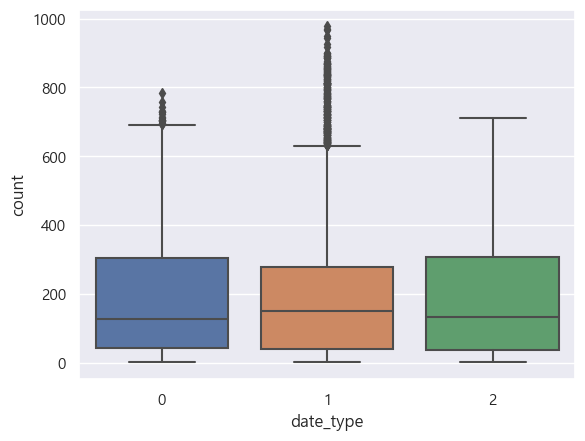

In [74]:
sns.boxplot(data=train, x='date_type', y='count')

<AxesSubplot: >

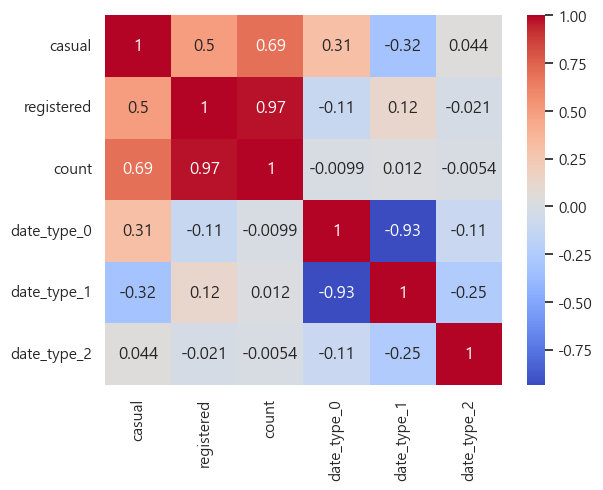

In [69]:
sns.heatmap(pd.get_dummies(train[['casual', 'registered', 'count', 'date_type']], columns=['date_type']).corr(), annot=True, cmap='coolwarm')

In [27]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 점수보기

In [ ]:
def my_fit_score(df) :
    model_list = [ 
                   ("RIDGE"  , Ridge(alpha=1.0, random_state=0)),
                   ("LASSO"  , Lasso(alpha=1.0, random_state=0)),
                   ("DTR"    , DecisionTreeRegressor(random_state=0)),
                   ("RF"     , RandomForestRegressor(random_state=0)),
                   ("LR"     , LinearRegression()                   ),
                   ("ABOOST" , AdaBoostRegressor(random_state=0)                  ),
                   ("XGB"    , XGBRegressor(random_state=0)                       ),  
                   ("LGBM"   , LGBMRegressor(random_state=0)                      ),
                   ("VR-XGB-LGBM"    , VotingRegressor([("XGB", XGBRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) ) ,
                   ("VR-RF-LGBM"    , VotingRegressor([("DTR", RandomForestRegressor(random_state=0)), ("LGBM", LGBMRegressor(random_state=0))]) )
                 ]
    
    #---------(타켓피쳐:로그스케일링) -----------
    # y_c = df['casual'] 
    # y_r = df['registered'] 
    y_c = np.log1p( df['casual'] )
    y_r = np.log1p( df['registered'] )
    # print(y_c[:5], y_r[:5])
    
    X = df.drop(['regcount','casual','registered'], axis=1)
    
    #------------------------------------------------
    # 연속형 피쳐 스케일링
    # 'temp', 'atemp','humidity', 'windspeed'
    #------------------------------------------------
    X['temp']      = np.log1p( X['temp'] )
    X['atemp']     = np.log1p( X['atemp'] )
    X['humidity']  = np.log1p( X['humidity'] )
    X['windspeed'] = np.log1p( X['windspeed'] )
    
    #------------------------------------------------
    # 이산형 피쳐 원핫인코딩
    # 'weather', 'season', 'y', 'm', 'h', 'w', 
    #------------------------------------------------

    
    for tpl in model_list :
        print( tpl[0] ) 
        
        model = tpl[1]
        X_train, X_test, y_train, y_r_test = train_test_split(X, y_r, random_state=0, test_size=0.2)
        model.fit(X_train, y_train)
        y_r_pred = model.predict(X_test)
        
        model = tpl[1]
        X_train, X_test, y_train, y_c_test = train_test_split(X, y_c, random_state=0, test_size=0.2)
        model.fit(X_train, y_train)
        y_c_pred = model.predict(X_test)
        
        #---------(타켓피쳐:로그스케일링) 복원-----------
        y_pred_comb = np.expm1(y_r_pred)+np.expm1(y_c_pred)
        y_real_comb = np.expm1(y_r_test)+np.expm1(y_c_test)
        y_pred_comb[y_pred_comb < 0] = 0
        
        # print("yrtest", y_r_test[:5])
        # print("yctest", y_c_test[:5])
        # print("ypred", y_pred_comb[:5])
        msle_score = mean_squared_log_error(y_real_comb, y_pred_comb)

        print("RMSLE: ", np.sqrt(msle_score)) 
        print("-"*30)

## 이상치 제거

In [21]:
# del_idx_list = []
# idx = train[train['windspeed']>=50].index
# del_idx_list.extend(idx)
# idx = train[train['weather']==4].index
# del_idx_list.extend(idx)
# idx = train[train['temp']>=40].index
# del_idx_list.extend(idx)
# print(train.shape)
# train = train.drop(del_idx_list, axis=0)
# print(train.shape)

# train, test 0값 처리

In [10]:
ws0 = train[train['windspeed']==0]
ws1 = train[train['windspeed']!=0]
ws0.shape, ws1.shape

((1313, 17), (9567, 17))

In [11]:
train_test_w0 = pd.concat([train[train['windspeed']==0], test[test['windspeed']==0]], axis=0)
train_test_w0.drop(['windspeed', 'casual', 'registered', 'count'], axis=1)

,season,holiday,workingday,weather,temp,atemp,humidity,y,m,d,h,w,date_type
regdate,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,2011,1,1,0,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,2011,1,1,1,5,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,2011,1,1,2,5,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,2011,1,1,3,5,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,2011,1,1,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-29 12:00:00,1,0,0,3,8.20,12.120,100,2012,12,29,12,5,0
2012-12-29 13:00:00,1,0,0,3,8.20,12.120,100,2012,12,29,13,5,0
2012-12-29 15:00:00,1,0,0,2,9.84,12.120,87,2012,12,29,15,5,0


In [21]:
train_test_w1 = pd.concat([train[train['windspeed']!=0], test[test['windspeed']!=0]], axis=0)
train_test_w0 = pd.concat([train[train['windspeed']==0], test[test['windspeed']==0]], axis=0)

X_train = train_test_w1.drop(['windspeed', 'casual', 'registered', 'count'], axis=1)
y_train = train_test_w1['windspeed']
X_test = train_test_w0.drop(['windspeed', 'casual', 'registered', 'count'], axis=1)
y_test_idx = train_test_w0['windspeed'].index

model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# train_test_w0['windspeed'] = y_pred


In [68]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
 8   y           6493 non-null   int64  
 9   m           6493 non-null   int64  
 10  d           6493 non-null   int64  
 11  h           6493 non-null   int64  
 12  w           6493 non-null   int64  
 13  date_type   6493 non-null   int64  
dtypes: float64(3), int64(11)
memory usage: 1018.9 KB


In [22]:
y_test_idx

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 06:00:00',
               '2011-01-01 07:00:00', '2011-01-01 08:00:00',
               '2011-01-01 09:00:00', '2011-01-03 19:00:00',
               ...
               '2012-12-29 00:00:00', '2012-12-29 02:00:00',
               '2012-12-29 03:00:00', '2012-12-29 08:00:00',
               '2012-12-29 09:00:00', '2012-12-29 12:00:00',
               '2012-12-29 13:00:00', '2012-12-29 15:00:00',
               '2012-12-29 23:00:00', '2012-12-30 19:00:00'],
              dtype='datetime64[ns]', name='regdate', length=2180, freq=None)

In [27]:
train.index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 05:00:00',
               '2011-01-01 06:00:00', '2011-01-01 07:00:00',
               '2011-01-01 08:00:00', '2011-01-01 09:00:00',
               ...
               '2012-12-19 14:00:00', '2012-12-19 15:00:00',
               '2012-12-19 16:00:00', '2012-12-19 17:00:00',
               '2012-12-19 18:00:00', '2012-12-19 19:00:00',
               '2012-12-19 20:00:00', '2012-12-19 21:00:00',
               '2012-12-19 22:00:00', '2012-12-19 23:00:00'],
              dtype='datetime64[ns]', name='regdate', length=10880, freq=None)

In [20]:
train_test_w0['windspeed'].index

DatetimeIndex(['2011-01-01 00:00:00', '2011-01-01 01:00:00',
               '2011-01-01 02:00:00', '2011-01-01 03:00:00',
               '2011-01-01 04:00:00', '2011-01-01 06:00:00',
               '2011-01-01 07:00:00', '2011-01-01 08:00:00',
               '2011-01-01 09:00:00', '2011-01-03 19:00:00',
               ...
               '2012-12-29 00:00:00', '2012-12-29 02:00:00',
               '2012-12-29 03:00:00', '2012-12-29 08:00:00',
               '2012-12-29 09:00:00', '2012-12-29 12:00:00',
               '2012-12-29 13:00:00', '2012-12-29 15:00:00',
               '2012-12-29 23:00:00', '2012-12-30 19:00:00'],
              dtype='datetime64[ns]', name='regdate', length=2180, freq=None)

랜덤포레스트 굿

In [ ]:
X_train = ws1.drop(['windspeed', 'casual', 'registered', 'regcount'], axis=1)
X_test  = ws0.drop(['windspeed', 'casual', 'registered', 'regcount'], axis=1)
y_train = ws1['windspeed']
print(X_train.shape, X_test.shape, y_train.shape)

model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred.shape

In [ ]:
plt.hist(y_pred)
plt.show()

In [ ]:
ws0['windspeed'] = y_pred
train = pd.concat([ws0,ws1]).sort_index()
train

# 최종 컬럼 선정
<pre>
타겟(1): 'casual' + 'registered'
   or
타겟(2): 'regcount'

삭제 컬럼: 'd',     'holiday', 'workingday',      'atemp',  'season'

시간 컬럼: 'y', 'm', 'h', 'w'

날짜 컬럼: 'day_type'

날씨 컬럼: 'season', 'weather', 'temp', 'humidity', 'windspeed'
       
       
다중공선: 분석피쳐중 상관계수가 높은 컬럼
'registered' <-> 'regcount' : regcount 삭제
'temp' <-> 'atemp' : atemp 삭제

'w' <-> 'day_type' : 나중에 고려대상
'season' <-> 'm' : season 삭제

결론
['casual', 'registered']
['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']

# 학습 ㄱㄱ

https://www.latex4technics.com/?note=CMEL1Z

*  $ MSE = \frac{\mathrm{1} }{\mathrm{n}} \sum\nolimits_{i=1}^{n} (Y_i - \hat{Y_i})^{2}$

*  $ MAE = \frac{\mathrm{1} }{\mathrm{n}} \sum\nolimits_{i=1}^{n} |Y_i - \hat{Y_i}|$

*  $ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{Y_i - \hat{Y_i}}{N}\Big)^2}}$

*  $ RMSLE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{log(Y_i+1) - log(\hat{Y_i}+1)}{N}\Big)^2}}$

In [ ]:
# !pip install xgboost
# !pip install lightgmb

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error

# 추가
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [ ]:
X = train[['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']]
Y = train[['regcount', 'registered', 'casual']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.2)
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, Y_train)
dtr_pred = dtr.predict(X_test)

dtr_mse_regcount = mean_squared_error(Y_test['regcount'], dtr_pred.T[0])
dtr_mse_registered = mean_squared_error(Y_test['registered'], dtr_pred.T[1])
dtr_mse_casual = mean_squared_error(Y_test['casual'], dtr_pred.T[2])

print(dtr_mse_regcount, dtr_mse_registered, dtr_mse_casual)

In [ ]:
X = train[['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']]
y_list = [train['regcount'], train['registered'], train['casual']]

for i, y in enumerate(y_list):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
    dtr = DecisionTreeRegressor(random_state=0)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    
    print(y_list[i].name)
    print('MSE', mse)
    print('RMSE', np.sqrt(mse))
    print()

In [ ]:
X = train[['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']]
y_list = [train['regcount'], train['registered'], train['casual']]
model_list = [
    ("DTR"   , DecisionTreeRegressor(random_state=0)),
    ("LR"    , LinearRegression()                   ),
    ("ABOOST", AdaBoostRegressor()                  ),
    ("XGB"   , XGBRegressor()                       ),  
    ("LGBM"  , LGBMRegressor()                      ),
    ("VR"    , VotingRegressor([("XGB", XGBRegressor()), ("LGBM", LGBMRegressor())]) ) 
]

res_list = []
for model_tuple in model_list:
    # print('model :', model_tuple[0])
    for i, y in enumerate(y_list):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
        model = model_tuple[1]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        res_list.append([model_tuple[0], y_list[i].name, mse, np.sqrt(mse)])
    #     print(y_list[i].name)
    #     print('MSE   : ', mse)
    #     print('RMSE  : ', np.sqrt(mse))
    #     print()
    # print('-----------------------------')
res_df = pd.DataFrame(res_list, columns=['model', 'target', 'MSE', 'RMSE'])
res_df

In [ ]:
res_df.pivot_table(index=['model', 'target'], values=['MSE', 'RMSE'])

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.barplot(res_df, x='model', y='MSE', hue='target')
plt.title('MSE')

plt.subplot(1,2,2)
sns.barplot(res_df, x='model', y='RMSE', hue='target')
plt.title('RMSE')

plt.show()

In [ ]:
sc_list = [
    ('Standard', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('Robust', RobustScaler())
]
X = train[['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']]
y_list = [train['regcount'], train['registered'], train['casual']]
model_list = [
    ("DTR"   , DecisionTreeRegressor(random_state=0)),
    ("LR"    , LinearRegression()                   ),
    ("ABOOST", AdaBoostRegressor()                  ),
    ("XGB"   , XGBRegressor()                       ),  
    ("LGBM"  , LGBMRegressor()                      ),
    ("VR"    , VotingRegressor([("XGB", XGBRegressor()), ("LGBM", LGBMRegressor())]) ) 
]

res_list = []
for j, sc in enumerate(sc_list):
    sc[1].fit(X)
    X = sc[1].transform(X)
    for model_tuple in model_list:
        # print('model :', model_tuple[0])
        for i, y in enumerate(y_list):
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
            model = model_tuple[1]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            res_list.append([sc[0], model_tuple[0], y_list[i].name, mse, np.sqrt(mse)])
        #     print(y_list[i].name)
        #     print('MSE   : ', mse)
        #     print('RMSE  : ', np.sqrt(mse))
        #     print()
        # print('-----------------------------')
res_df = pd.DataFrame(res_list, columns=['Scaler', 'model', 'target', 'MSE', 'RMSE'])
res_df

In [ ]:
res_df.sort_values('MSE')

In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.barplot(res_df, x='model', y='MSE', hue='target')
plt.title('MSE')

plt.subplot(1,2,2)
sns.barplot(res_df, x='model', y='RMSE', hue='target')
plt.title('RMSE')

plt.show()